In [92]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima as pm

import functions as fn


In [93]:
district = "Adilabad"

In [94]:
aqi_df = pd.read_csv("data/monthly_aqi_data.csv")
aqi_df.head()


,district,month,aqi,year
0,Nizamabad,Jan,61.333333333333336,2017
1,Nizamabad,Feb,61.55555555555556,2017
2,Nizamabad,Mar,63.22222222222222,2017
3,Nizamabad,Apr,67.37037037037038,2017
4,Nizamabad,May,68.40740740740742,2017


In [95]:

aaq_df = pd.read_csv("data/monthly_aaq_data.csv")
aaq_df.head()


,district,month,SO2,NOx,PM10,PM2.5,NH3,year
0,Khammam,Jan,6.0,19.0,46.0,NaN,NaN,2016
1,Khammam,Feb,7.0,19.0,51.0,NaN,NaN,2016
2,Khammam,Mar,6.1,20.7,54.0,NaN,NaN,2016
3,Khammam,Apr,8.0,19.0,51.0,NaN,NaN,2016
4,Khammam,May,7.0,19.0,47.0,NaN,NaN,2016


### Nizamabad
We'll be trying out 3 models to forecast AQI
1. ARIMA on AQI
2. ARIMAX on AQI with SO2, NOx and PM10 as exogenous variables
3. VARMAX on AQI, SO2, NOx and PM10.

The model giving the best result will be used for all other districts.


In [96]:
df = fn.combine_aqi_aaq(aqi_df=aqi_df, aaq_df=aaq_df, district=district)
df.head()
# df.isna().sum()


,district,aqi,date,SO2,NOx,PM10
12,Adilabad,63.666667,2017-01-01,5.0,21.0,64.0
13,Adilabad,63.555556,2017-02-01,5.0,21.0,64.0
14,Adilabad,67.666667,2017-03-01,6.0,20.0,68.0
15,Adilabad,68.962963,2017-04-01,5.0,20.0,69.0
16,Adilabad,70.629630,2017-05-01,5.0,19.0,71.0


<Axes: xlabel='date'>

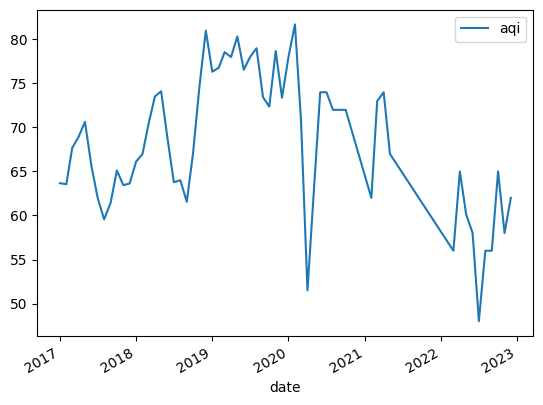

In [97]:
df.set_index("date", inplace=True)
df.plot(y='aqi')


In [98]:
# seasonal decomposition
# seasonal_decomp = sm.tsa.seasonal_decompose(df['aqi'], model='additive')
# seasonal_decomp.plot()
# plt.show()


In [99]:
holt_winter = sm.tsa.ExponentialSmoothing(
    df['aqi'], seasonal='add', seasonal_periods=12)
x = holt_winter.fit(smoothing_seasonal=0.1)
x.params


/home/rohan/dev/tai/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


{'smoothing_level': 0.4962048748320455,
 'smoothing_trend': nan,
 'smoothing_seasonal': 0.1,
 'damping_trend': nan,
 'initial_level': 63.90047818478798,
 'initial_trend': nan,
 'initial_seasons': array([ 1.02537827, -0.19849185,  1.26267136, -2.09491439,  3.31591712,
        -1.03500967, -1.23373365, -1.694095  , -1.6926603 , -3.24015171,
         2.21303165,  2.76905022]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

/home/rohan/dev/tai/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/rohan/dev/tai/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: >

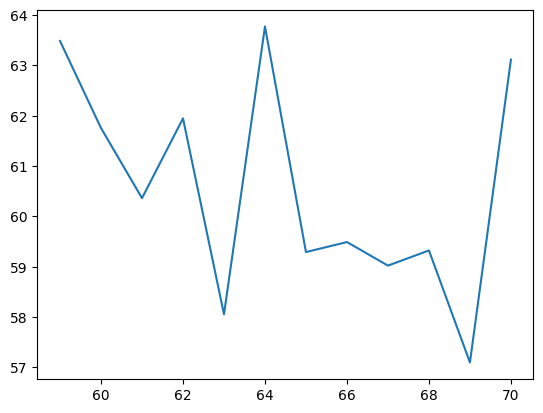

In [100]:
df['predict_holt'] = list(x.predict(1, len(df)))
# df[['aqi', 'predict_holt']].plot()
x.forecast(12).plot()


In [101]:

sm.stats.acorr_ljungbox(x.resid, lags=[10], return_df=True)



,lb_stat,lb_pvalue
10,17.97551,0.055378


In [102]:
from pathlib import Path
save_location = Path("..", "pickles", district)
x.save(fname=save_location.absolute())